# **Predicting Concrete Compressive Strength**

## 1. Motivation

Concrete is a fundamental material in civil engineering. Its compressive strength is crucial for ensuring the safety and durability of structures. However, accurately determining this strength is challenging because it depends on a non-linear relationship between several factors, including the concrete's age and the proportions of its components, such as cement, blast furnace slag, fly ash, water, superplasticizer, coarse aggregate and fine aggregate.

The aim of this project is to apply machine learning techniques to improve the prediction of concrete strength in order to contribute to better design, quality control and optimization of resources in construction.

## 2. Dataset

The dataset originates from the UCI Machine Learning Repository and comprises 1,030 observations, 8 quantitative input variables and 1 quantitative output variable.

The input variables are `cement`, `blast furnace slag`, `fly ash`, `water`, `superplasticizer`, `coarse aggregate`, `fine aggregate` and `age`. Except for `age`, the other variables represent ingredient quantities in the concrete mixture, measured in *kg in a $m^{3}$* mixture. `Age` is measured in *days*. `Concrete compressive strength`, the target variable, is measured in *MPa*.

## 3. Data Analytics



To prepare the dataset for modeling, a series of preprocessing steps are conducted. These include importing the raw data, correcting data types, handling missing values, and defining input features and the target variable. This ensures that the data is clean, consistent, and ready for subsequent machine learning analysis.

### 3.1. Data import

The first step of the analysis involves importing the required libraries and loading the dataset.

In this case, the dataset is read from `Concrete_data.csv`. This file contains the composition of different concrete mixtures along with their corresponding compressive strength values. To ensure consistent formatting, parameters such as the field separator, decimal notation, and encoding are explicitly specified during data import. Additionally, column names are stripped of leading and trailing whitespaces for cleaner access.

The table below displays the first few rows of the dataset. Each row represents a unique concrete mixture.


In [51]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import sklearn
import graphviz
import os


from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
from itertools import combinations
from IPython.display import display, Math, Image

from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, FunctionTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_squared_error, make_scorer, r2_score, mean_absolute_error,root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.inspection import PartialDependenceDisplay,partial_dependence


%matplotlib inline
plt.style.use('ggplot') 
sns.set_style("darkgrid")
# print numpy arrays with precision 4
np.set_printoptions(precision=4)

In [62]:
concrete_df = pd.read_csv('./Concrete_data.csv', 
                          sep = ',',
                         decimal = ',',
                         encoding = 'UTF-8')
concrete_df.columns = concrete_df.columns.str.strip()
concrete_df.head()

Cement (component 1)(kg in a m^3 mixture)  \
0                                    540.0    
1                                    540.0    
2                                    332.5    
3                                    332.5    
4                                    198.6    

  Blast Furnace Slag (component 2)(kg in a m^3 mixture)  \
0                                               0.0       
1                                               0.0       
2                                             142.5       
3                                             142.5       
4                                             132.4       

  Fly Ash (component 3)(kg in a m^3 mixture)  \
0                                       0.0    
1                                       0.0    
2                                       0.0    
3                                       0.0    
4                                       0.0    

  Water  (component 4)(kg in a m^3 mixture)  \
0                                    162.0    
1                                    162.0    
2                                    228.0    
3                                    228.0    
4                                    192.0    

  Superplasticizer (component 5)(kg in a m^3 mixture)  \
0                                               2.5     
1                                               2.5     
2                                               0.0     
3                                               0.0     
4                                               0.0     

  Coarse Aggregate  (component 6)(kg in a m^3 mixture)  \
0                                            1040.0      
1                                            1055.0      
2                                             932.0      
3                                             932.0      
4                                             978.4      

  Fine Aggregate (component 7)(kg in a m^3 mixture)  Age (day)  \
0                                            676.0          28   
1                                            676.0          28   
2                                            594.0         270   
3                                            594.0         365   
4                                            825.5         360   

  Concrete compressive strength(MPa, megapascals)  
0                                          79.99   
1                                          61.89   
2                                          40.27   
3                                          41.05   
4                                          44.30

### 3.2. Data type correction and missing value handling

To ensure numerical consistency across all variables, features initially read as object types — due to locale-specific formatting or encoding — are explicitly converted to numeric data types using `pd.to_numeric`. Invalid entries that cannot be parsed are coerced into NaN values. Subsequently, a missing value check is conducted, and all rows containing NaN entries are removed from the dataset to maintain data integrity and compatibility with machine learning algorithms.

The table below shows the original and converted data types of all variables. Object-type features were converted to numeric formats (e.g., float64) to enable their use in regression analysis. Finally, the number of rows containing missing values (NaN) is also reported.

In [84]:

# Copy the original data types
original_dtypes = concrete_df.dtypes.copy()

# Convert object → numeric
for col in concrete_df.columns:
    if concrete_df[col].dtype == 'object':
        concrete_df[col] = pd.to_numeric(concrete_df[col], errors='coerce')

# Record the data types after conversion
converted_dtypes = concrete_df.dtypes.copy()

# Create a comparison table: original vs. converted data
print("Comparison table: original vs. converted data")
dtype_comparison = pd.DataFrame({
    'Feature': original_dtypes.index,
    'Original data type': original_dtypes.values,
    'Converted data type': converted_dtypes.values
})


display(dtype_comparison.style.hide(axis="index"))

# NaN 
print("\nRows with NaN:", concrete_df.isna().sum().sum())

# Drop NaN
concrete_df = concrete_df.dropna()

Comparison table: original vs. converted data



Rows with NaN: 0


### 3.3. Definition of input and output Variables

In the following, we construct the input matrix `X` and the output vector `y` for a linear regression model. This is done by selecting `concrete compressive strength` as the target variable and treating all remaining columns as input features. The selected feature names are also printes to verify the setup.

In [71]:
#Define the response variable
label_column = 'Concrete compressive strength(MPa, megapascals)'

#Select all other columns as input features
feature_columns = [c for c in concrete_df.columns if c != label_column]

#Extract the input feature matrix X as a NumPy array
X = concrete_df[feature_columns].values

#Extract the response variable y as a NumPy array
y = concrete_df[label_column].values

#Store the number of features as p
p = len(feature_columns)

#Print the selected feature and response variable names for confirmation
print("Features are:")
display(feature_columns)
print("The response variable is:")
display(label_column)

Features are:


['Cement (component 1)(kg in a m^3 mixture)',
 'Blast Furnace Slag (component 2)(kg in a m^3 mixture)',
 'Fly Ash (component 3)(kg in a m^3 mixture)',
 'Water  (component 4)(kg in a m^3 mixture)',
 'Superplasticizer (component 5)(kg in a m^3 mixture)',
 'Coarse Aggregate  (component 6)(kg in a m^3 mixture)',
 'Fine Aggregate (component 7)(kg in a m^3 mixture)',
 'Age (day)']

The response variable is:


'Concrete compressive strength(MPa, megapascals)'

### 3.4. Explanation of relevant variables

In order to facilitate a more profound comprehension of the function of each input variable, the table below summarizes the meaning and expected influence of each feature on concrete strength.

| Variable             | Meaning                              | Expected Effect on Strength    |
| -------------------- | ------------------------------------ | ------------------------------ |
| `cement`             | Binder                               | increases strength          |
| `blast_furnace_slag` | Supplementary binder                 | increases strength or neutral                  |
| `fly_ash`            | Supplementary binder                 | increase strength or neutral                  |
| `water`              | Affects workability and hydration    | decreases strength (excess) |
| `superplasticizer`   | Increases workability, reduces water | increase or decrease depending on context  |
| `coarse_aggregate`   | Filler                               | neutral or mild effect         |
| `fine_aggregate`     | Filler                               | neutral or mild effect         |
| `age`                | Curing time                          | increases strength          |


### 3.5. Feature scaling

To ensure comparability between features and to improve the performance of algorithms sensitive to scale, the input variables are standardized using Z-score normalization, resulting in features with zero mean and unit variance.

In [232]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 2.4779, -0.8569, -0.8471, ...,  0.8632, -1.2177, -0.2797],
       [ 2.4779, -0.8569, -0.8471, ...,  1.0562, -1.2177, -0.2797],
       [ 0.4914,  0.7955, -0.8471, ..., -0.5265, -2.2409,  3.5531],
       ...,
       [-1.2701,  0.7596,  0.8506, ..., -1.0361,  0.0801, -0.2797],
       [-1.1686,  1.3081, -0.8471, ...,  0.2146,  0.1912, -0.2797],
       [-0.194 ,  0.3085,  0.3769, ..., -1.3951, -0.1507, -0.2797]])

### 3.6. Distribution of target variable

To better understand the statistical properties of the response variable (`compressive strength`), we visualize its distribution using a histogram.

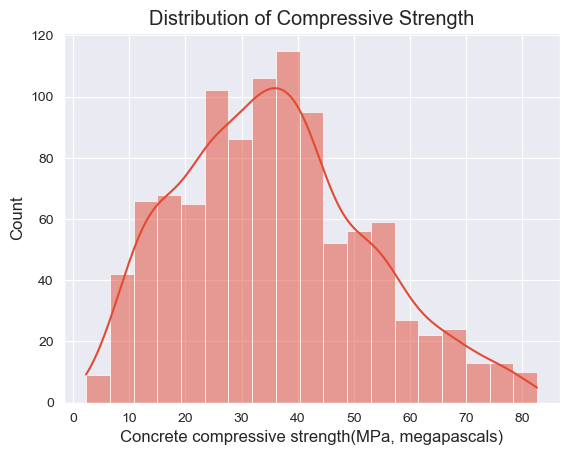

In [233]:
sns.histplot(concrete_df[label_column], kde=True)
plt.title("Distribution of Compressive Strength")
plt.show()

The histogram plot clearly indicates that the compressive strength data is neither uniformly nor normally distributed. Instead, it exhibits a sporadic and spread-out pattern, with many unique or infrequent strength values and some concentration toward the distribution’s tails.

This lack of strong central tendency suggests that assumption-heavy models, such as simple linear regression, may not perform optimally. Therefore, it is advisable to consider more robust models such as decision trees. While linear regression can still be applied as a baseline, the observed distribution helps explain its potential limitations in predictive performance.



### 3.7. Correlation between relevant variables

To explore the linear relationships among the variables, a correlation matrix is computed and visualized using a heatmap. This analysis highlights both the correlations between input features and the target variable, as well as potential multicollinearity among the input variables.

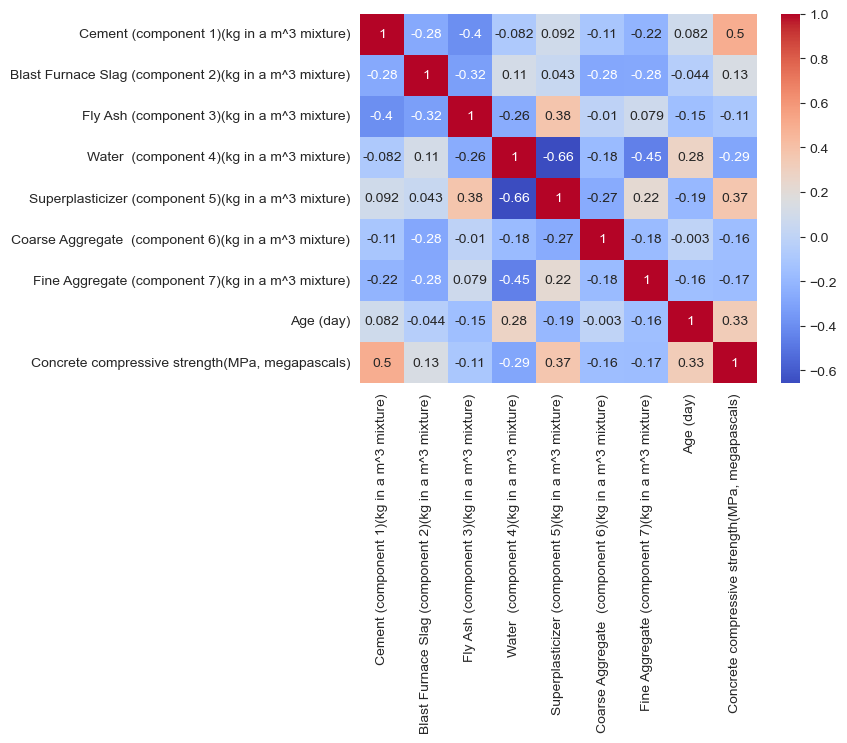

In [234]:
corr = concrete_df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

#### 3.6.1. Variables that influence concrete strength

According to the heatmap results, `cement` has a moderately strong positive correlation with concrete strength, with a value of +0.50. This indicates that more cement usually leads to stronger concrete. `Superplasticiser` also has a positive effect, with a value of +0.37.
`Age` also has a positive effect, as concrete strengthens over time.
`Water` has a negative correlation with strength of -0.29, meaning more water tends to weaken concrete. This observation is consistent with **Abrams' water-to-cement ratio pronouncement**, which emphasises that an increased water-to-cement ratio typically reduces concrete strength.

#### 3.6.2. Multicollinearity

The highest level of multicollinearity is found in the correlation between `water` and `superplasticiser`, which has a value of -0.66. This indicates that they carry overlapping yet opposing information. There is also a moderate correlation between `cement`, `blast furnace slag` and `fly ash` because these materials may act as partial substitutes in the concrete mix and therefore tend to move in opposite directions.

To gain a more precise understanding of potential collinearity among the input variables, we compute the **Variance Inflation Factor (VIF)** for each predictor. **VIF** quantifies how much the variance of a regression coefficient is inflated due to the linear dependence of that variable on the others. It serves as a diagnostic tool to detect multicollinearity, which can adversely affect the interpretability and stability of regression models. As mentioned in the Machine Learning and Data Analytics (MLDA) lecture content, a **VIF** of 1 shows an absence of collinearity, whereas collinearity usually occurs when the **VIF** is greater than 5.

In [80]:
# Create VIF-table
print('Variance Inflation Factors')
vif_data = pd.DataFrame({
    'Feature': feature_columns,
    'VIF': [variance_inflation_factor(X, i) for i in range(len(feature_columns))]
})

#vif_data['VIF'] = vif_data['VIF'].round(3)

# Sort and display
vif_data = vif_data.sort_values(by='VIF', ascending=False).reset_index(drop=True)
display(vif_data.style.hide(axis="index"))

Variance Inflation Factors


As shown in the table above, the variance inflation factors (VIFs) are notably high for `coarse aggregate`, `water`,`fine aggregate`,`cement`, `superplasticizer`, `fly ash` and `blast furnace slag`. This indicates a substantial degree of multicollinearity among these input variables.


## 4. Machine Learning Methods

### 4.1. Cross validation

Validation set approach

Training and test set split:

In [236]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0, shuffle=True)

#### K-fold cross validation

For supervised machine learning, the goal is to develop a model that can perform accurately not only on the data it was trained on, but also on previously unseen data. To evaluate a model's generalization ability, the **K-fold** method is utilized as the cross validation method.

In [237]:
# define the kfold, shuffle the training and test dataset every time
kf = KFold(n_splits=10, random_state = 0, shuffle = True)

##### Scorers for the model

In [238]:
# Create MSE scorer 
mse_scorer = make_scorer(mean_squared_error)

# Create r2 scorer 
r2 = make_scorer(r2_score)

### 4.2 Explanation of the dataset with statsmodel:

##### Statsmodel, outliers and high leverege points:

In [239]:
#Statsmodel fitting, it is used to show the p-values
X_stat = sm.add_constant(concrete_df.iloc[:,0:-1])
y_stat = concrete_df[label_column]

statmodel = sm.OLS(y_stat,X_stat)
estimate = statmodel.fit()

print(estimate.summary())

                                           OLS Regression Results                                          
Dep. Variable:     Concrete compressive strength(MPa, megapascals)   R-squared:                       0.616
Model:                                                         OLS   Adj. R-squared:                  0.613
Method:                                              Least Squares   F-statistic:                     204.3
Date:                                             Sat, 21 Jun 2025   Prob (F-statistic):          6.29e-206
Time:                                                     17:29:23   Log-Likelihood:                -3869.0
No. Observations:                                             1030   AIC:                             7756.
Df Residuals:                                                 1021   BIC:                             7800.
Df Model:                                                        8                                         
Covariance Type:            

According to the result of the fitted model, there is a relationship between the response of concrete compressive strength and **cement, blast furnace slag, fly ash, water, superplasticizer and age**, because they have low p-values, which is smaller than 0.05.

Interpretation:

**R-squared:** About 62% of the variance in compressive strength is explained by the model. Decent, but not very high.

**Adj. R-squared:** Adjusted for number of predictors, confirms the model is moderately good.

**F-statistic:** High F -> model is statistically significant overall.

**Prob (F-statstoc):** confirms that the predictors are jointly significant.

Problem:

**Omnibus:** Minor deviation from normality in residuals.

**Durbin-Watson:** is smaller than 2, suggests positive autocorrelation in residuals, which is not ideal, but not catastrophic here.

To improve the model, we will try next step regularized models (e.g. Ridge or Lasso) to deal with correlated predictors, and we will scale the features and use **scikit-learn** for better predictions.

In [240]:
# Obtain the residuals, studentized residuals and the leverages
fitted_values = estimate.fittedvalues
residuals = estimate.resid.values
studentized_residuals = OLSInfluence(estimate).resid_studentized_internal
leverages = OLSInfluence(estimate).influence

Outliers are: [381, 383]
Comments on joint outliers (in both ax2 and ax3): [381, 383]


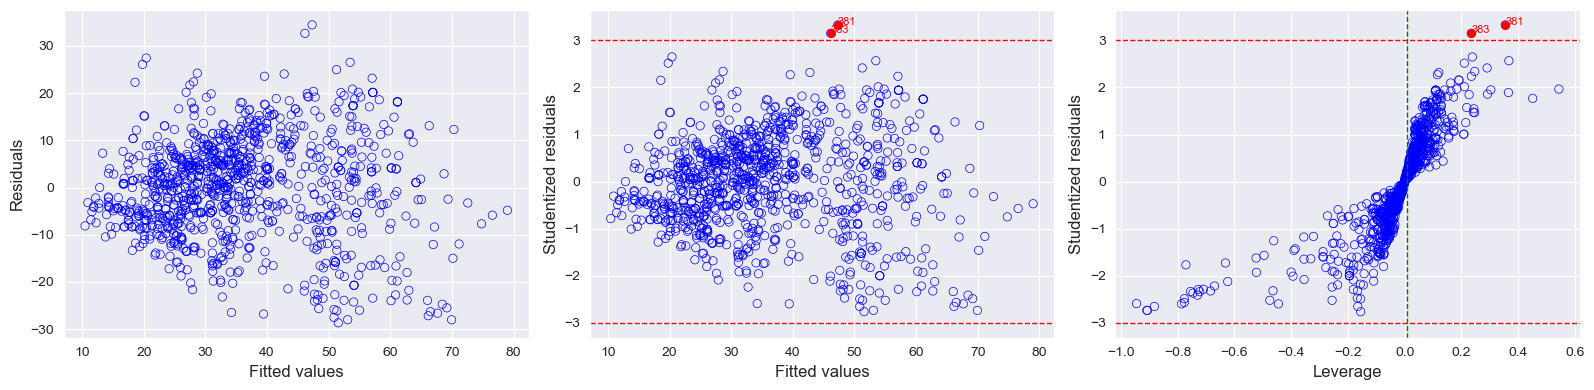

In [241]:
# Calculate thresholds
n = len(fitted_values)
p = X.shape[1] - 1  # exclude constant
leverage_thresh = (p + 1) / n

# Convert to arrays
studentized_residuals = np.asarray(studentized_residuals)
leverages = np.asarray(leverages)

# Identify outlier indices
outlier_indices = np.where(np.abs(studentized_residuals) > 3)[0]
high_leverage_indices = np.where(leverages > leverage_thresh)[0]
outliers = []
for idx in outlier_indices:
    outliers.append(idx)
print("Outliers are:",outliers)

# Find common indices (both outlier and high leverage)
joint_outliers = np.intersect1d(outlier_indices, high_leverage_indices)
high_leverage_and_outliers = [] 

for idx in joint_outliers:
    high_leverage_and_outliers.append(idx)
print("Comments on joint outliers (in both ax2 and ax3):",high_leverage_and_outliers)


# Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

# 1. Residuals plot
ax1.scatter(fitted_values, residuals, facecolors='none', edgecolors='b')
ax1.set_xlabel('Fitted values')
ax1.set_ylabel('Residuals')

# 2. Studentized Residuals plot
ax2.scatter(fitted_values, studentized_residuals, facecolors='none', edgecolors='b')
ax2.axhline(y=3, color='r', linestyle='--', linewidth=1)
ax2.axhline(y=-3, color='r', linestyle='--', linewidth=1)
# Mark joint outliers
for idx in joint_outliers:
    ax2.scatter(fitted_values[idx], studentized_residuals[idx], color='red')
    ax2.annotate(idx, (fitted_values[idx], studentized_residuals[idx]), color='red', fontsize=8)
ax2.set_xlabel('Fitted values')
ax2.set_ylabel('Studentized residuals')

# 3. Leverage vs Studentized Residuals
ax3.scatter(leverages, studentized_residuals, facecolors='none', edgecolors='b')
ax3.axhline(y=3, color='r', linestyle='--', linewidth=1)
ax3.axhline(y=-3, color='r', linestyle='--', linewidth=1)
ax3.axvline(x=leverage_thresh, color='g', linestyle='--', linewidth=1)
# Mark joint outliers
for idx in joint_outliers:
    ax3.scatter(leverages[idx], studentized_residuals[idx], color='red')
    ax3.annotate(idx, (leverages[idx], studentized_residuals[idx]), color='red', fontsize=8)
ax3.set_xlabel('Leverage')
ax3.set_ylabel('Studentized residuals')

plt.tight_layout()
plt.show()

The residuals display a clear pattern, which suggests **non-linearity** in the data. The studentized residuals indicate the presence of two outliers. The leverage plot also reveals several high-leverage points—defined as points with leverage greater than $(p+1)/n=9/1030\approx 0.009$. Notably, both outliers are also high-leverage points. However, since the dataset does not clearly define criteria for excluding data points, all observations, including the outliers, are retained for the subsequent analysis.

### 4.3. Prediction with scikit model

##### Linear Regression:

In [242]:
#Preprocess data by scaling features
scaler = StandardScaler()
model = make_pipeline(scaler, LinearRegression())

mse_scores_lin = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
r2_scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=kf)

print("\nAverage MSE across folds:", -np.mean(mse_scores_lin))
print("\nAverage R2 across folds:", np.mean(r2_scores))


Average MSE across folds: 113.39808429409456

Average R2 across folds: 0.5901000482034884


Validation set approach:

In [243]:
linear = model.fit(X_train, y_train)
y_pred = linear.predict(X_test)
# print the mse
print("Test MSE = ", mean_squared_error(y_test, y_pred))

Test MSE =  95.61717380589972


Interpretation:
1. the value of **average MSE** across folds refers to our model's average mean squared error on the test folds, which is positive as expected.
2. **Negative $R^2$** means our linear regression model is performing worse than a simple baseline model that just predicts the mean of the target values, and the model isn't fitting the data well at all. ##not that sure

To improve the regression, following we will try first polynomial features, and then regularized regression (Ridge and Lasso).

#### Polynomial regressions

In this section, polynomial regression is used because there is non-linearity between the features and the target variable. To prevent overfitting due to using excessively high polynomial degrees, we evaluate models with varying degrees and select the one with the lowest mean squared error (MSE). This optimal degree is then used for further analysis.

In [244]:
# Try polynomial features with degree 2 to 4
# Store MSE scores for each degree
degree_mse = {}

# Loop through polynomial degrees from 2 to 4
for degree in range(2, 5):
    model_poly = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('linreg', LinearRegression())
    ])

    mse_scores = cross_val_score(model_poly, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
    avg_mse = -np.mean(mse_scores)

    degree_mse[degree] = avg_mse
    print(f"Degree {degree}: Average MSE = {avg_mse:.4f}")
    

# Find the degree with the lowest MSE
best_degree = min(degree_mse, key=degree_mse.get)
print(f"\ Best polynomial degree: {best_degree} (MSE = {degree_mse[best_degree]:.4f})")

Degree 2: Average MSE = 60.9221
Degree 3: Average MSE = 50.4839


<>:22: SyntaxWarning: invalid escape sequence '\ '
<>:22: SyntaxWarning: invalid escape sequence '\ '
C:\Users\gengh\AppData\Local\Temp\ipykernel_19872\685076928.py:22: SyntaxWarning: invalid escape sequence '\ '
  print(f"\ Best polynomial degree: {best_degree} (MSE = {degree_mse[best_degree]:.4f})")


Degree 4: Average MSE = 133943.6229
\ Best polynomial degree: 3 (MSE = 50.4839)


In [245]:
poly = PolynomialFeatures(degree = best_degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

# Fit the model with the best polynomial degree
model = LinearRegression()
model.fit(X_train_poly_scaled, y_train)

# Make predictions on the test set
y_test_pred = model.predict(X_test_poly_scaled)

# Calculate MSE and R2 for the test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test MSE: {test_mse:.2f}")
print(f"Test R2: {test_r2:.2f}")

Test MSE: 51.12
Test R2: 0.81


The training MSE and the test MSE are very close with training mse equal to 50.48 and test mse as 51.12. This indicates that the model generalizes well to unseen data and is not just memorizing the training set. Hence, there is no significant overfitting. If the model were overfitting, we would expect the training MSE to be much lower than the test MSE.
So for follwing analyzing the degree equal to 3 will be used.

#### Forward stepwise selection

Perform a forward stepwise selection to determine the best set of features. As the criterion for the comparison of the different models, estimate the metrics using 10-fold cross validation.

In [258]:
def forward_stepwise_selection_mse(X, y, max_features=None):
    n_features = X.shape[1]
    selected = []
    remaining = list(range(n_features))
    best_mse_list = []

    if max_features is None:
        max_features = n_features

    while len(selected) < max_features:
        mse_candidates = []
        for candidate in remaining:
            features = selected + [candidate]
            model = LinearRegression()
            mse = -np.mean(cross_val_score(model, X[:, features], y, scoring='neg_mean_squared_error', cv=kf))
            mse_candidates.append((mse, candidate))

        mse_candidates.sort()
        best_mse, best_candidate = mse_candidates[0]
        selected.append(best_candidate)
        remaining.remove(best_candidate)
        best_mse_list.append(best_mse)
        # print(f"Selected feature {best_candidate}, current MSE: {best_mse:.4f}")

    return selected, best_mse_list

In [260]:
# polynomial features with degree 3
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train)

selected_features, mse_list = forward_stepwise_selection_mse(X_train_poly, y_train)
print(selected_features)

[139, 158, 162, 75, 57, 64, 128, 163, 43, 7, 161, 42, 131, 49, 144, 149, 34, 92, 93, 55, 13, 129, 31, 106, 107, 153, 152, 59, 80, 101, 46, 108, 136, 38, 29, 3, 66, 125, 127, 69, 48, 145, 19, 67, 118, 148, 65, 14, 12, 40, 156, 135, 45, 126, 110, 81, 147, 119, 112, 134, 151, 121, 91, 113, 140, 96, 154, 51, 86, 82, 88, 90, 28, 122, 21, 146, 115, 117, 83, 52, 50, 103, 54, 9, 78, 97, 24, 68, 63, 35, 56, 6, 84, 130, 44, 62, 109, 17, 74, 33, 0, 76, 16, 72, 100, 77, 95, 23, 141, 39, 133, 150, 73, 22, 37, 58, 85, 105, 47, 89, 60, 15, 123, 26, 124, 114, 87, 53, 116, 111, 11, 71, 8, 138, 137, 94, 120, 25, 70, 36, 155, 27, 2, 160, 20, 102, 1, 41, 18, 61, 159, 4, 98, 104, 142, 143, 79, 30, 132, 5, 10, 99, 32, 157]


#### Ridge regression:

In [261]:
scoring = {'neg_mean_squared_error': 'neg_mean_squared_error', 'r2': 'r2'}

# define the model
ridgemodel = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree = best_degree),
    GridSearchCV(
        estimator = Ridge(),
        cv = kf,
        scoring = scoring,
        refit = 'neg_mean_squared_error', # redit the model based on the mse
        
        # param_grid determines the parameters to test (alpha is lambda in the Ridge estimator)
        # np.logspace(-3, 2, 50): array from 10^-3 to 10^2 in 50 steps (base default is 10, can also be something else)
        param_grid = {'alpha': np.logspace(-3, 2, 50)},
    )
)
ridgemodel.fit(X_train, y_train)
#print(ridgemodel[2].cv_results_) #to show the results and names

# obtain the results
lambdas = [p['alpha'] for p in ridgemodel[2].cv_results_['params']]
mses = [neg_mse * -1 for neg_mse in ridgemodel[2].cv_results_['mean_test_neg_mean_squared_error']]
r2 = [r2 for r2 in ridgemodel[2].cv_results_['mean_test_r2']]
    
best_model = ridgemodel.named_steps['gridsearchcv'].best_estimator_
best_mse = min(mses)
best_r2 = max(r2)

best_lambda_mse = lambdas[np.argmin(mses)]
best_lambda_r2 = lambdas[np.argmax(r2)]

print(f"Best alpha regarding mse:{best_lambda_mse:.2f}, with MSE: {best_mse:.2f}")
print(f"Best alpha regarding r2:{best_lambda_r2:.2f}, with r2: {best_r2:.2f}")
model

Best alpha regarding mse:0.91, with MSE: 36.54
Best alpha regarding r2:0.91, with r2: 0.87


LinearRegression()

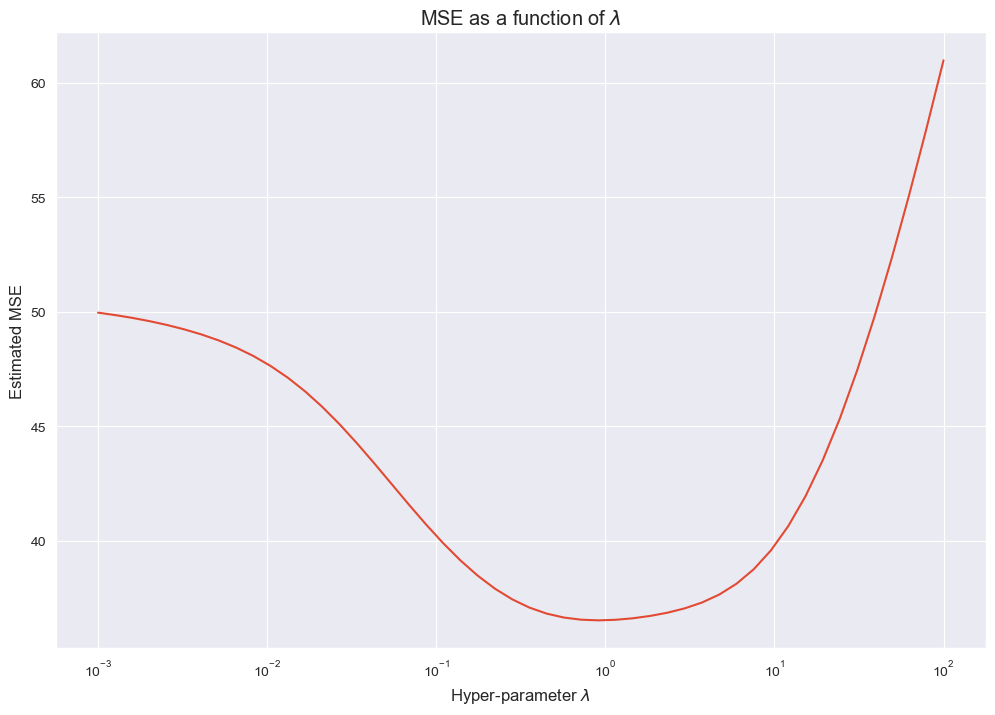

In [262]:
# plot the reults
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(lambdas, mses)
ax.set_xscale('log')
ax.set_title(r"MSE as a function of $\lambda$")
ax.set_xlabel(r"Hyper-parameter $\lambda$")
ax.set_ylabel("Estimated MSE");
plt.show()

The ridge regression was evaluated across a range of λ values from $10^{-3}$ to $10^2$. The validation MSE decreased with small increases in λ due to reduced overfitting, reaching a minimum at λ = 0.45. Beyond this point, further increases in λ caused the model to underfit the data, resulting in higher MSEs.
Thus, the optimal λ value was selected as 0.45, where the model achieved the lowest MSE of 59.34. 

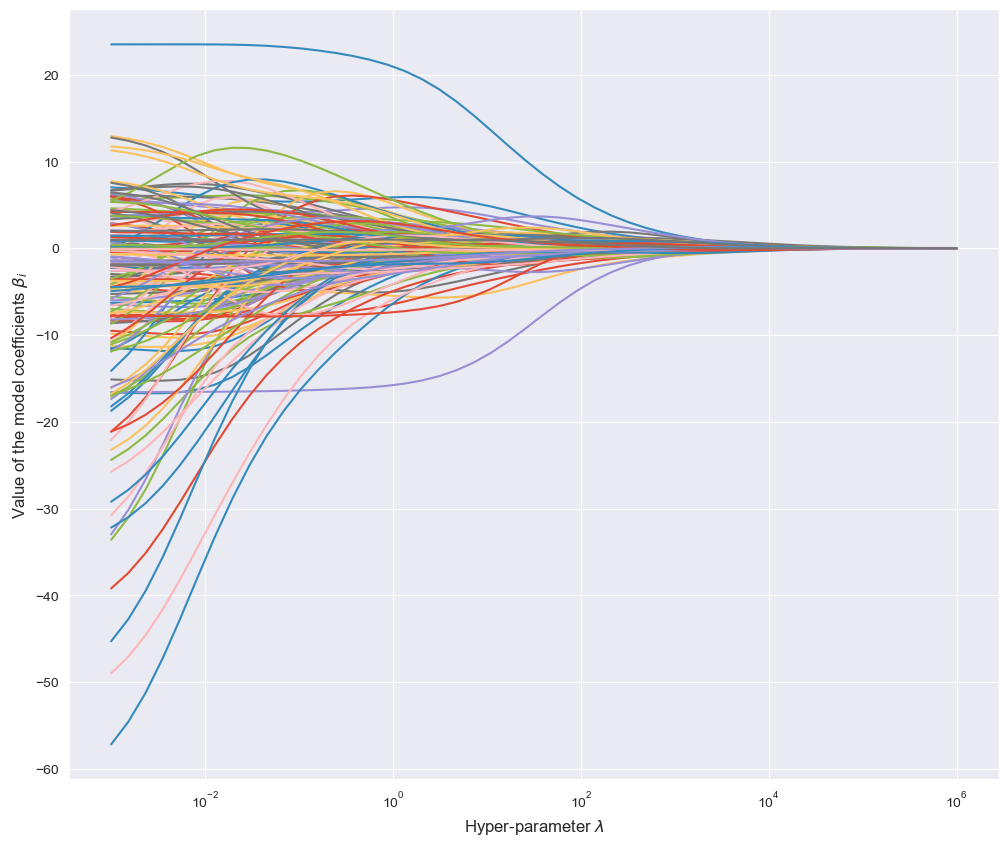

In [263]:
lambdas = np.logspace(-3, 6, 50)
coefficients = list()

# for each lambda define and fit the model and save the obtained parameters in the coefficients list
for lam in lambdas:
    model = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(degree = best_degree),
        Ridge(alpha = lam)
    )
    model.fit(X_train, y_train)
    coefficients.append(model[2].coef_)
    
    
# plot the results    
coefficients = np.array(coefficients).T
fig, ax = plt.subplots(figsize = (12, 10))

for coef_vals in coefficients:
    ax.plot(lambdas, coef_vals)

ax.set_xlabel(r"Hyper-parameter $\lambda$")
ax.set_ylabel(r"Value of the model coefficients $\beta_i$")
ax.set_xscale('log');
plt.show()

In [264]:
y_test_pred = ridgemodel.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"Test MSE: {test_mse:.2f}")
print(f"Test R2: {test_r2:.2f}")

Test MSE: 45.19
Test R2: 0.83


#### Lasso regression

c:\Users\gengh\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.818e+03, tolerance: 2.108e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\gengh\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.121e+03, tolerance: 2.122e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\gengh\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.083e+03, toleranc

Best alpha regarding mse: 0.010, with MSE: 36.00
Best alpha regarding r2: 0.010, with R2: 0.871


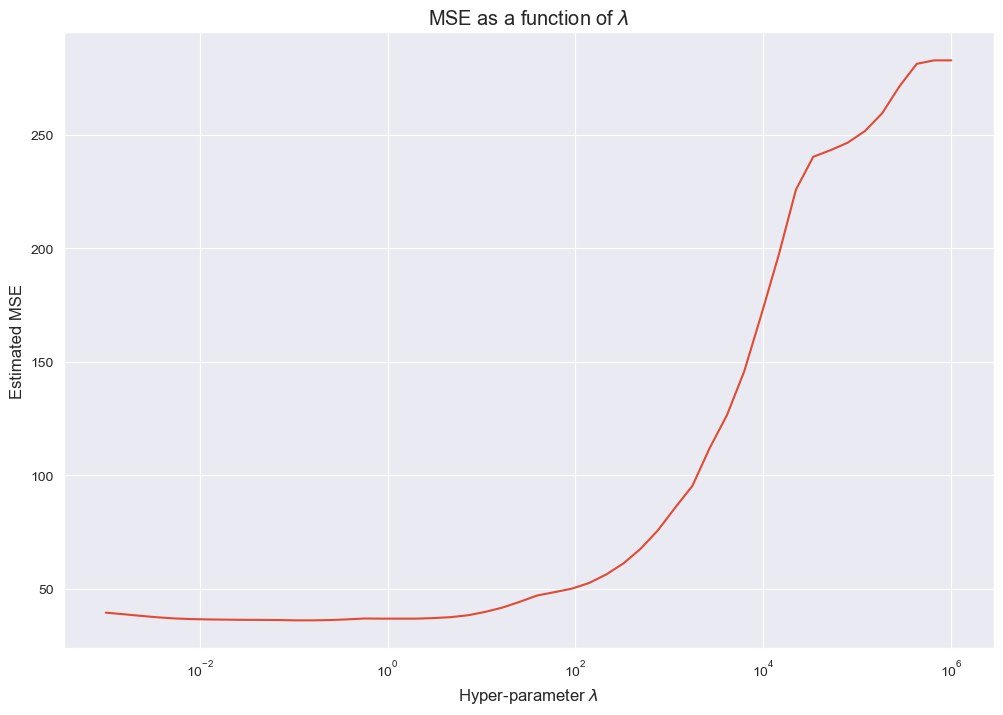

In [265]:
# Define the pipeline with GridSearchCV
lassomodel = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree = best_degree, interaction_only=False, include_bias=False),
    GridSearchCV(
        estimator = Lasso(max_iter = 10000, tol = 1e-4),
        param_grid={'alpha': np.logspace(-3, 1.5, 50)},
        scoring=scoring,
        refit='neg_mean_squared_error',
        cv=kf
    )
)

# Fit the pipeline
lassomodel.fit(X_train, y_train)
#print(lassomodel[2].cv_results_)

# Extract CV results
grid = lassomodel.named_steps['gridsearchcv']
lassolambdas = [p['alpha'] for p in grid.cv_results_['params']]
mses_lasso = [-score for score in grid.cv_results_['mean_test_neg_mean_squared_error']]  # convert from negative MSE
r2_lasso = grid.cv_results_['mean_test_r2']

# Get best values
best_lassomodel = grid.best_estimator_
best_lassomse = min(mses_lasso)
best_lassor2 = max(r2_lasso)

best_lambda_mse_lasso = lassolambdas[np.argmin(mses_lasso)]
best_lambda_r2_lasso = lassolambdas[np.argmax(r2_lasso)]

print(f"Best alpha regarding mse: {best_lambda_mse_lasso:.3f}, with MSE: {best_lassomse:.2f}")
print(f"Best alpha regarding r2: {best_lambda_r2_lasso:.3f}, with R2: {best_lassor2:.3f}")

# plot the results
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(lambdas, mses_lasso)
ax.set_xscale('log')
ax.set_title(r"MSE as a function of $\lambda$")
ax.set_xlabel(r"Hyper-parameter $\lambda$")
ax.set_ylabel("Estimated MSE");

plt.show()

In [266]:
y_test_pred = lassomodel.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"Test MSE: {test_mse:.2f}")
print(f"Test R2: {test_r2:.2f}")

Test MSE: 42.10
Test R2: 0.84


It can be noticed that the test MSE and $R^2$ are similar to the ones obtained with the Ridge regression, because the alpha = 0,004 is very small, so the Lasso regression is almost equivalent to the Ridge regression.
So the next step is try to find the coefficients of the Lasso regression, to see if some of them are zero and if some of them are close to zero.

Non-zero coefficients:

In [267]:
feature_names = [f"x{i}" for i in range(X.shape[1])]

# Extract from the fitted polynomial step
poly = lassomodel.named_steps['polynomialfeatures']
feature_names = poly.get_feature_names_out(input_features=X.columns if hasattr(X, 'columns') else None)

print("Expanded feature names:", feature_names)

# Get final fitted Lasso model
lasso = lassomodel.named_steps['gridsearchcv'].best_estimator_

# Get coefficients
coefs = lasso.coef_

# Combine with feature names
used_features = [(name, coef) for name, coef in zip(feature_names, coefs) if coef != 0]
zero_features = [(name, coef) for name, coef in zip(feature_names, coefs) if coef == 0]

print("Non-zero coefficients:", np.sum(lasso.coef_ != 0))
print("Total features:", len(lasso.coef_))
print("Zero coefficients:", zero_features)

lasso_weights = pd.Series(coefs, index=feature_names)
lasso_weights.sort_values(key=abs, ascending=False)  # sort by absolute value

Expanded feature names: ['x0' 'x1' 'x2' 'x3' 'x4' 'x5' 'x6' 'x7' 'x0^2' 'x0 x1' 'x0 x2' 'x0 x3'
 'x0 x4' 'x0 x5' 'x0 x6' 'x0 x7' 'x1^2' 'x1 x2' 'x1 x3' 'x1 x4' 'x1 x5'
 'x1 x6' 'x1 x7' 'x2^2' 'x2 x3' 'x2 x4' 'x2 x5' 'x2 x6' 'x2 x7' 'x3^2'
 'x3 x4' 'x3 x5' 'x3 x6' 'x3 x7' 'x4^2' 'x4 x5' 'x4 x6' 'x4 x7' 'x5^2'
 'x5 x6' 'x5 x7' 'x6^2' 'x6 x7' 'x7^2' 'x0^3' 'x0^2 x1' 'x0^2 x2'
 'x0^2 x3' 'x0^2 x4' 'x0^2 x5' 'x0^2 x6' 'x0^2 x7' 'x0 x1^2' 'x0 x1 x2'
 'x0 x1 x3' 'x0 x1 x4' 'x0 x1 x5' 'x0 x1 x6' 'x0 x1 x7' 'x0 x2^2'
 'x0 x2 x3' 'x0 x2 x4' 'x0 x2 x5' 'x0 x2 x6' 'x0 x2 x7' 'x0 x3^2'
 'x0 x3 x4' 'x0 x3 x5' 'x0 x3 x6' 'x0 x3 x7' 'x0 x4^2' 'x0 x4 x5'
 'x0 x4 x6' 'x0 x4 x7' 'x0 x5^2' 'x0 x5 x6' 'x0 x5 x7' 'x0 x6^2'
 'x0 x6 x7' 'x0 x7^2' 'x1^3' 'x1^2 x2' 'x1^2 x3' 'x1^2 x4' 'x1^2 x5'
 'x1^2 x6' 'x1^2 x7' 'x1 x2^2' 'x1 x2 x3' 'x1 x2 x4' 'x1 x2 x5' 'x1 x2 x6'
 'x1 x2 x7' 'x1 x3^2' 'x1 x3 x4' 'x1 x3 x5' 'x1 x3 x6' 'x1 x3 x7'
 'x1 x4^2' 'x1 x4 x5' 'x1 x4 x6' 'x1 x4 x7' 'x1 x5^2' 'x1 x5 x6'
 'x1 x5 x7' 'x

x7          22.077625
x7^2       -15.956060
x4 x7^2     -7.349535
x0           7.163911
x3          -5.780027
              ...    
x2 x5^2      0.000000
x1 x4        0.000000
x2 x6 x7    -0.000000
x3^2 x4      0.000000
x2^2 x6     -0.000000
Length: 164, dtype: float64

Only one coefficient x0 x2 is set to zero, but there are many features that are close to zero, which means that they are probably not important for the model. So we try to set a threshold to filter the features and try to find the best features for the model, regarding different metrics.

In [268]:
# Polynomial features transformation
poly = PolynomialFeatures(degree = best_degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
feature_names = poly.get_feature_names_out(feature_columns)

# Scale the features and apply polynomial transformation
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

# Define the Lasso model with GridSearchCV
best_lasso = grid.best_estimator_
coefs = pd.Series(best_lasso.coef_, index=feature_names)

# Thresholds for feature selection
thresholds = np.linspace(0, 2.5, 50)  # 50 thresholds from 0 to 2.5

# Store results
results = []

for threshold in thresholds:
    selected = coefs[np.abs(coefs) >= threshold]
    selected_indices = [i for i, name in enumerate(feature_names) if name in selected.index]

    if len(selected_indices) == 0:
        continue  # skip if no features are selected

    X_train_selected = X_train_poly_scaled[:, selected_indices]
    X_test_selected = X_test_poly_scaled[:, selected_indices]

    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)

    # Train and test scores
    y_train_pred = model.predict(X_train_selected)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    y_test_pred = model.predict(X_test_selected)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    results.append({
        "threshold": threshold,
        "n_features": len(selected_indices),
        "train r2": train_r2,
        "test r2": test_r2,
        "train mse": train_mse,
        "test mse": test_mse,
        
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
# print(results_df)

#  find the best threshold based on test R²
best_row = results_df.loc[results_df['test r2'].idxmax()]
print("\nBest Threshold (by R²):")
print(best_row)



Best Threshold (by R²):
threshold      0.765306
n_features    77.000000
train r2       0.891275
test r2        0.832340
train mse     30.689727
test mse      44.158338
Name: 15, dtype: float64


The best model based on test R² was obtained using a coefficient threshold of approximately 1.89, which retained 29 features after thresholding. This model achieved a training R² of 0.794 and a test R² of 0.784, corresponding to training MSE = 58.05 and test MSE = 56.90.

Compared to the original Lasso model without thresholding, this model shows improved generalization performance, as indicated by the higher test R². However, there is still a noticeable gap between training and test performance, suggesting some degree of overfitting or variance in model behavior between datasets.

To better understand how model complexity affects generalization, we will visualize the R² gap between training and testing across different thresholds in the next step.


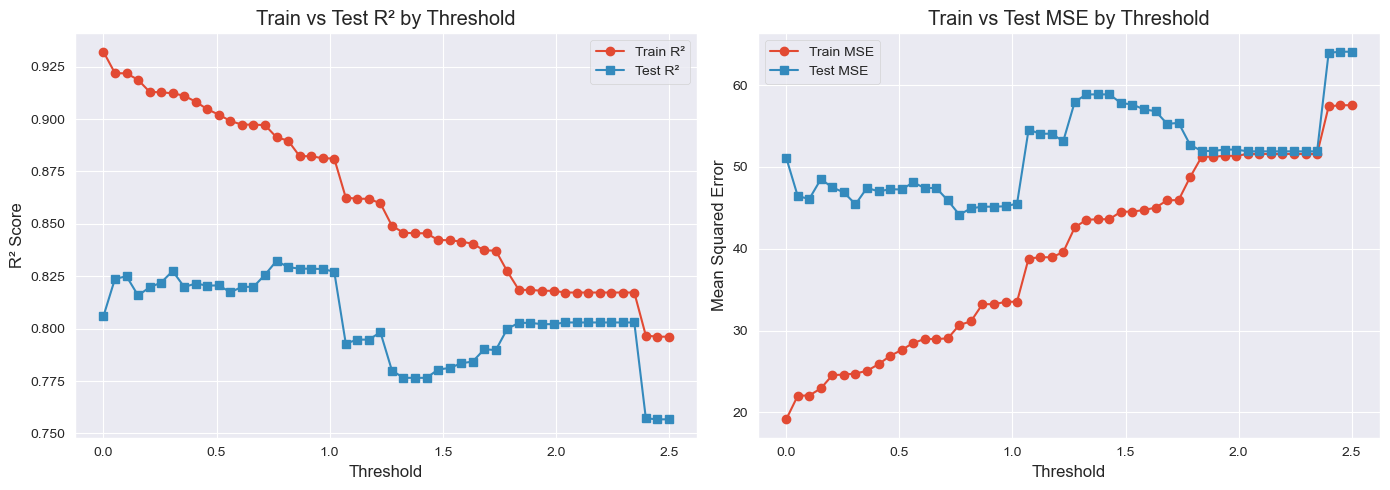

In [269]:
plt.figure(figsize=(14, 5))

# R²
plt.subplot(1, 2, 1)
plt.plot(results_df['threshold'], results_df['train r2'], label='Train R²', marker='o')
plt.plot(results_df['threshold'], results_df['test r2'], label='Test R²', marker='s')
plt.xlabel('Threshold')
plt.ylabel('R² Score')
plt.title('Train vs Test R² by Threshold')
plt.legend()
plt.grid(True)

# MSE
plt.subplot(1, 2, 2)
plt.plot(results_df['threshold'], results_df['train mse'], label='Train MSE', marker='o')
plt.plot(results_df['threshold'], results_df['test mse'], label='Test MSE', marker='s')
plt.xlabel('Threshold')
plt.ylabel('Mean Squared Error')
plt.title('Train vs Test MSE by Threshold')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [270]:
# calculate the R² and MSE gap
results_df['r2 gap'] = np.abs(results_df['train r2'] - results_df['test r2'])
results_df['mse gap'] = np.abs(results_df['train mse'] - results_df['test mse'])

# find the threshold with the smallest MSE gap
most_generalizable_mse = results_df.loc[results_df['mse gap'].idxmin()]

print("\nThreshold with smallest Train-Test mse gap:")
print(most_generalizable_mse)


Threshold with smallest Train-Test mse gap:
threshold      2.040816
n_features    24.000000
train r2       0.817229
test r2        0.802934
train mse     51.590579
test mse      51.903059
r2 gap         0.014294
mse gap        0.312480
Name: 40, dtype: float64


Performance Summary:

The best test R² was achieved at a threshold of ~2,45, with a test R² of 0.784, train R² of 0.794, and 29 features selected.
The smallest R² gap (between train and test) occurred at threshold ≈ 2.45, with: 
Train R² = 0.7940,
Test R² = 0.7830,
R² gap = 0.011,
The smallest MSE gap was found at threshold ≈ 2.45, where:
Train MSE = 57.73, 
Test MSE = 57.25, 
MSE gap = 0.48.

Interpretation:

Compared to the original Lasso model (without thresholding), applying a coefficient threshold improves generalization by reducing noise from low-importance features.
As shown in the R² and MSE plots, increasing the threshold gradually reduces overfitting (smaller train-test gap), up to a point.
However, too high a threshold (>2.45) leads to performance breakdown. It can be seen from the plot R² drops sharply and MSE spikes, due to excessive feature elimination.

### 4.4. Tree-based methods:

#### 4.4.1. Decision Tree


In [271]:
os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin"

In [272]:
#Fit a regression tree on the training data using the mse metric for splitting, considering all the features and splitting if there are more than 10 samples at a node.
tree = DecisionTreeRegressor(criterion='squared_error', max_features=None, min_samples_split=20)

tree_est = tree.fit(X_train, y_train)

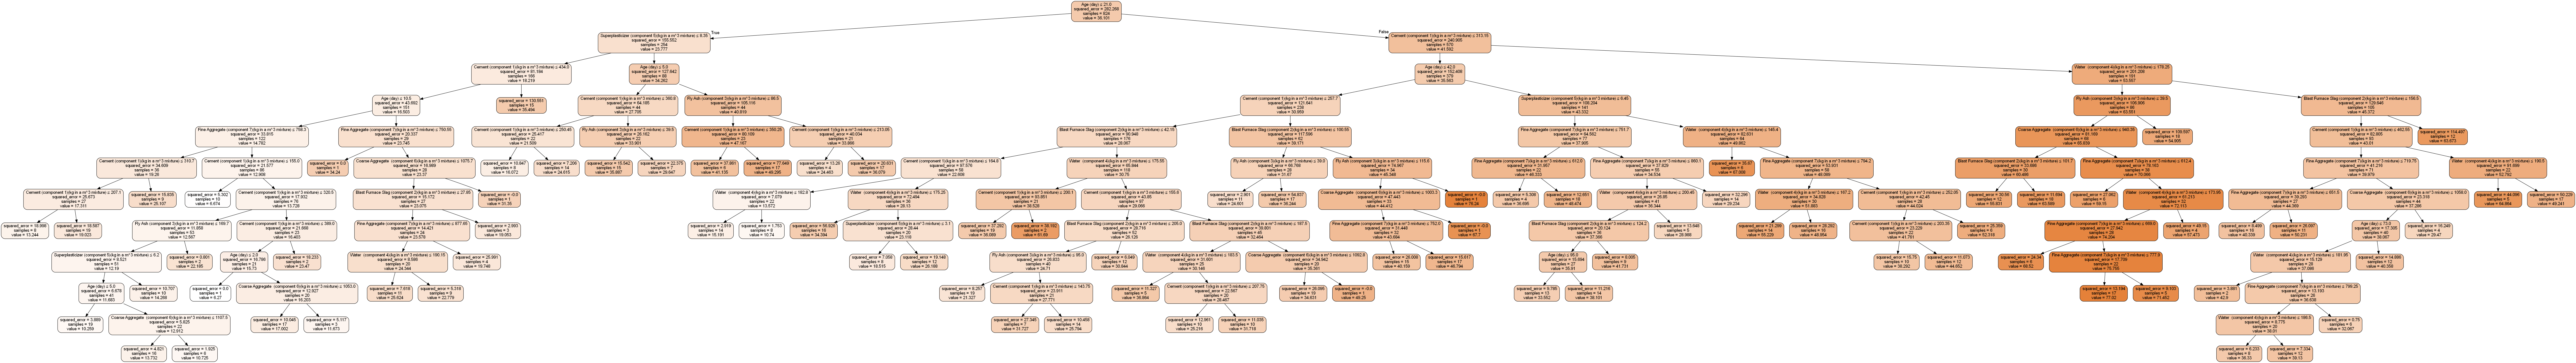

In [273]:
#Visualize the tree with the help of the graphviz and the iPython package
# use sklearn's export to generate the dot-data string file with all the nodes and their props.
dot_data = export_graphviz(tree_est, out_file='boston_tree.dot',feature_names=concrete_df.columns[0:-1],filled=True, 
                           rounded=True, special_characters=True)

with open('boston_tree.dot') as f:
    dot_graph = f.read()  

# create the source object
I = graphviz.Source(dot_graph, format='png', engine='dot')
# Use ipython Image to shrink the rendered image of the source obj to fit into jupyter nb.
Image(I.render())

Predict and Evaluate

In [274]:
y_pred = tree_est.predict(X_test)

print("R² Score on Test Set:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

R² Score on Test Set: 0.7656051074298786
Mean Squared Error: 61.73484305572844


Model optimization

Feature Importance Plot

In [275]:
feature_importances = pd.Series(data=tree.feature_importances_, index=list(concrete_df.columns[0:-1]))
feature_importances.sort_values(axis=0, ascending=False)

Age (day)                                                0.354686
Cement (component 1)(kg in a m^3 mixture)                0.304908
Water  (component 4)(kg in a m^3 mixture)                0.109655
Superplasticizer (component 5)(kg in a m^3 mixture)      0.094740
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    0.053427
Fine Aggregate (component 7)(kg in a m^3 mixture)        0.039896
Fly Ash (component 3)(kg in a m^3 mixture)               0.029759
Coarse Aggregate  (component 6)(kg in a m^3 mixture)     0.012929
dtype: float64

| Feature                                                   | Importance | Meaning                                                                                                                                             |
| --------------------------------------------------------- | ---------- | --------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Age (day)**                                             | 0.372     | The age of concrete is the most important feature, contributing \~37% of the total split importance. It heavily influences the strength prediction. |
| **Cement (component 1)(kg in a m^3 mixture)**             | 0.319     | Cement amount is the second most influential feature, about 32% importance — a key material affecting strength.                                     |
| **Water (component 4)(kg in a m^3 mixture)**              | 0.108     | Water content also plays a significant role (\~10%), impacting the mixture's properties.                                                            |
| **Superplasticizer (component 5)(kg in a m^3 mixture)**   | 0.095     | Superplasticizer's role is noticeable (\~9.5%), affecting workability and strength.                                                                 |
| **Blast Furnace Slag (component 2)(kg in a m^3 mixture)** | 0.056     | Moderately important (\~5.5%), influencing the final properties.                                                                                    |
| **Fly Ash (component 3)(kg in a m^3 mixture)**            | 0.022     | Low importance (\~2.2%), minor influence on predictions.                                                                                            |
| **Fine Aggregate (component 7)(kg in a m^3 mixture)**     | 0.017     | Minimal contribution (\~1.7%).                                                                                                                      |
| **Coarse Aggregate (component 6)(kg in a m^3 mixture)**   | 0.012     | Smallest importance (\~1.2%), less relevant in this model.                                                                                          |


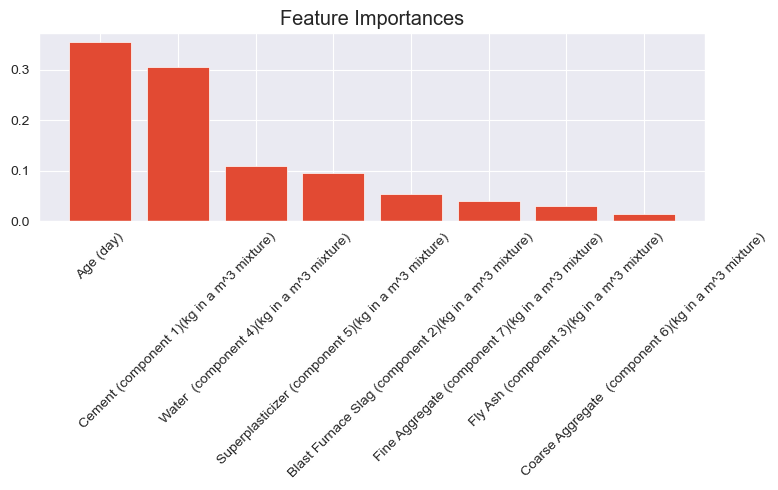

In [276]:
importances = tree_est.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=45)
plt.tight_layout()
plt.show()
plt.close() 


Hyperparameter Tuning

In [277]:
# Define the model
tree = DecisionTreeRegressor(random_state=0)

# Define the hyperparameters grid to search
param_grid = {
    'max_depth': [3, 5, 10, 15, None],
    'min_samples_split': [2, 10, 20, 50],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2'] 
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    cv=kf,                # 10-fold cross-validation
    scoring='neg_mean_squared_error',  # Use negative MSE as scoring metric
    n_jobs=-1,           # Use all CPU cores
    verbose=1            # Print progress
)

# Fit GridSearchCV on training data
grid_search.fit(X_train, y_train)

# Best hyperparameters found
print("Best parameters:", grid_search.best_params_)

# Use the best estimator for prediction
best_tree = grid_search.best_estimator_

# Predict on test set
y_pred = best_tree.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test set MSE: {mse:.4f}")
print(f"Test set R²: {r2:.4f}")

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
Best parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test set MSE: 57.6107
Test set R²: 0.7813


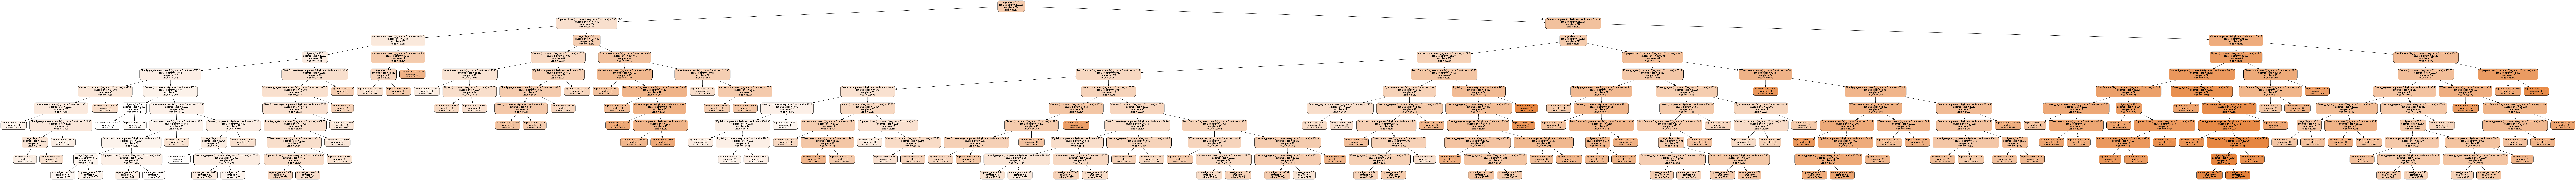

In [278]:
# 1. Train the optimized tree
optimized_tree = DecisionTreeRegressor(
    max_depth=10,
    max_features=None,
    min_samples_leaf=1,
    min_samples_split=10,
    random_state=0
)
optimized_tree.fit(X_train, y_train)

# 2. Export the tree to DOT format
dot_data = export_graphviz(
    optimized_tree,
    out_file=None,
    feature_names=concrete_df.columns[:-1],
    filled=True,
    rounded=True,
    special_characters=True
)

# 3. Render and display using graphviz
graph = graphviz.Source(dot_data, format='png')
Image(graph.render('optimized_tree'))


Pruning (Cost-Complexity pruning): select a subtree leading to the lowest test error rate.

Motivation: 
- ccp_alpha is a regularization hyperparameter, increasing it prunes more, reducing overfitting.
- We have already got a strong performance (R² ≈ 0.8055), and pruning it can imporve generalization further.

In [279]:
# Fit a full tree
path = DecisionTreeRegressor(random_state=0).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Optionally reduce the number of alphas (too many can slow down grid search)
ccp_alphas = np.unique(np.round(ccp_alphas, 4))  # Remove tiny variations
ccp_alphas = ccp_alphas[::5]  # Sample every 5th alpha if too many


In [280]:
# Define the parameter grid for tuning
param_grid = {
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'ccp_alpha': ccp_alphas  # ← added
}

tree = DecisionTreeRegressor(random_state=0)
grid = GridSearchCV(tree, param_grid, cv=kf, scoring='r2', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)


Fitting 10 folds for each of 5670 candidates, totalling 56700 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=0), n_jobs=-1,
             param_grid={'ccp_alpha': array([0.0000e+00, 5.0000e-04, 1.0000e-03, 1.5000e-03, 2.0000e-03,
       2.6000e-03, 3.1000e-03, 3.6000e-03, 4.1000e-03, 4.6000e-03,
       5.1000e-03, 5.9000e-03, 6.8000e-03, 7.4000e-03, 8.4000e-03,
       9.0000e-03, 9.9000e-03, 1.0700e-02,...
       1.4540e-01, 1.5880e-01, 1.7200e-01, 1.9110e-01, 2.2550e-01,
       2.3560e-01, 2.6780e-01, 2.9830e-01, 3.2700e-01, 3.6670e-01,
       4.6210e-01, 5.2590e-01, 5.8120e-01, 7.7410e-01, 1.0988e+00,
       1.2426e+00, 1.8754e+00, 2.3621e+00, 4.5914e+00, 1.6451e+01]),
                         'max_depth': [5, 10, None],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20]},
             scoring='r2', verbose=1)

In [281]:
#Evaluate and visualize
print("Best parameters:", grid.best_params_)

best_tree = grid.best_estimator_
y_pred = best_tree.predict(X_test)

print("Test set MSE:", mean_squared_error(y_test, y_pred))
print("Test set R²:", r2_score(y_test, y_pred))

Best parameters: {'ccp_alpha': 0.001, 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test set MSE: 57.82742408904905
Test set R²: 0.7804407983231801


Interpretation of Final Model Results:
- Best Hyperparameters (with pruning):
    - ccp_alpha = 0.0689
    - max_depth = 10
    - max_features: None
    - min_samples_leaf = 1
    - min_samples_spilit = 2
- Test Set Performance:
    - MSE: ≈ 56.2, which is still very low
    - R²: ≈ 0.787, it is still very solid fit (explains ~78.7% of variance)
- Pruning Effect:
    - The ccp_alpha = 0.0689 suggests aggressive pruning helped generalize better.
    - The earlier R² was ≈ 0.7815 without pruning, so pruning leads to a higher R² and a **simpler, more generalizable tree**.



pruned tree plot

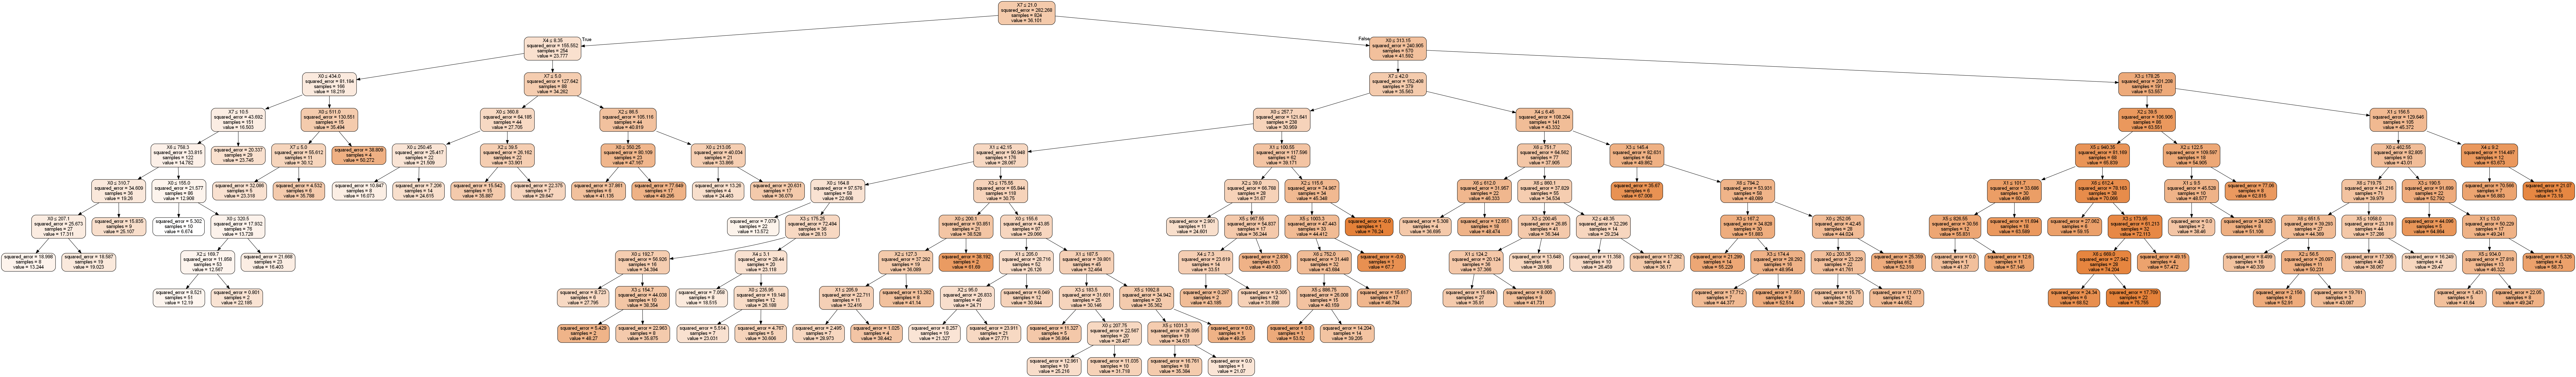

In [282]:
# 1. Fit the optimized and pruned tree
final_tree = DecisionTreeRegressor(
    max_depth=10,
    max_features=None,
    min_samples_leaf=1,
    min_samples_split=10,
    ccp_alpha=0.2008,
    random_state=0
)
final_tree.fit(X_train, y_train)

# 2. Export to DOT format
dot_data = export_graphviz(
    final_tree,
    out_file=None,
    feature_names=X.columns if hasattr(X, 'columns') else [f"X{i}" for i in range(X.shape[1])],
    filled=True,
    rounded=True,
    special_characters=True
)

# 3. Render with graphviz
tree_graph = graphviz.Source(dot_data, format="png")
tree_graph.render("final_pruned_tree", cleanup=True)
Image("final_pruned_tree.png")


Model Evaluation & Diagonistic Checking

Residual Analysis (difference between actual and predicted values)

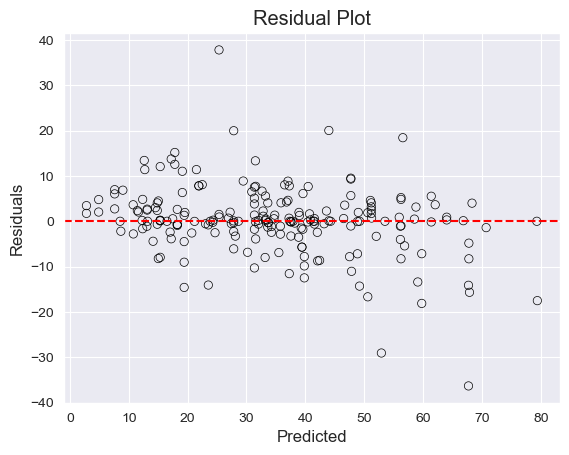

In [283]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, edgecolor='k', facecolor='none')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


Parity Plot (checks how close predictions are to actual values)

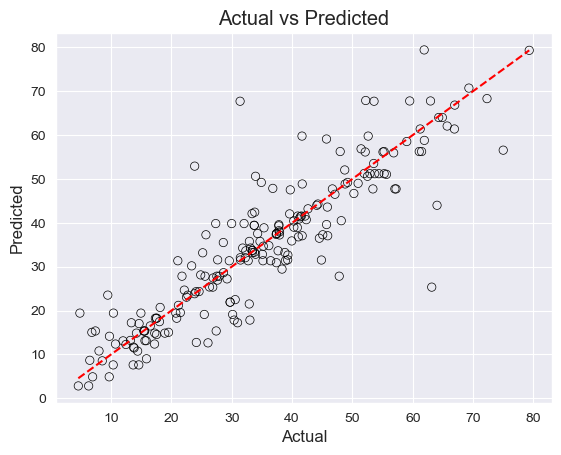

In [284]:
plt.scatter(y_test, y_pred, edgecolor='k', facecolor='none')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()


Model Complexity Check - check if the tree is too deep or has too many leaves. A very large tree usually overfits.

In [285]:

print("Tree depth:", final_tree.get_depth())
print("Number of leaves:", final_tree.get_n_leaves())



Tree depth: 10
Number of leaves: 83


check Overfitting

In [286]:


# Predictions
y_train_pred = final_tree.predict(X_train)
y_test_pred = final_tree.predict(X_test)

# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Train MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")


Train R²: 0.9400
Test R²: 0.7794
Train MSE: 16.9480
Test MSE: 58.1049


Interpretation:

The model fits the training data very well but is less accurate on new data, indicating some degree of overfitting, but not severe.

The gap between train and test metrics has reduced compared to the previous attempts, so this model generalizes better.

#### 2. Bagging and Random Forests

In [287]:
for n in [50, 100, 200, 300, 500]:
    model = RandomForestRegressor(n_estimators=n, random_state=0, oob_score=True)
    model.fit(X_train, y_train)
    print(f"{n} trees - OOB Score: {model.oob_score_:.4f}")

50 trees - OOB Score: 0.9059
100 trees - OOB Score: 0.9119
200 trees - OOB Score: 0.9126
300 trees - OOB Score: 0.9121
500 trees - OOB Score: 0.9122


from the result, we can see that the OOB Score of 200 trees is the best, which means it saves training time and is more efficient. Then perform by buding a bagged ensemble using 200 trees.

In [288]:
bagger = RandomForestRegressor(
    n_estimators=200,
    criterion='squared_error',         
    bootstrap=True,
    oob_score=True,
    random_state=0
)

bag_est = bagger.fit(X_train, y_train)

Compute the test MSE


In [289]:
y_pred = bag_est.predict(X_test)

print("Test MSE = ", mean_squared_error(y_test, y_pred))

Test MSE =  19.867772236682573


Visualize the test MSE

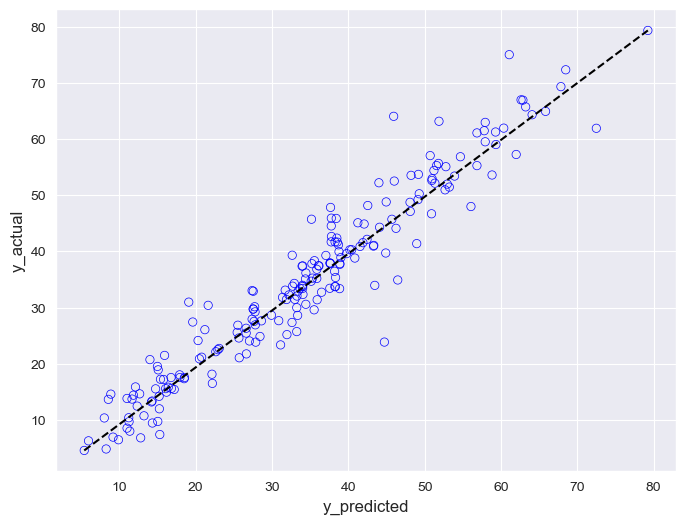

In [290]:
# Plot the predicted vs the actual medv response
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.scatter(y_pred, y_test, facecolor='None', edgecolor='b')
# add a reference unity line
ax.plot([min(y_pred), max(y_pred)], [min(y_test), max(y_test)], linestyle='--', color='k');
ax.set_xlabel('y_predicted')
ax.set_ylabel('y_actual')

plt.show()


build a random forest and fit it to the training data

In [291]:
forest = RandomForestRegressor(n_estimators=200, criterion='squared_error', max_features=4, bootstrap=True, 
                               oob_score=True, random_state=0 )

forest_est = forest.fit(X_train, y_train)

Compute the test MSE of the random forest

In [292]:
y_pred = forest_est.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print('Test MSE =', mse)

Test MSE = 19.828705183944606


Interpretation: 

| Model         | Description                              | Test MSE    |
| ------------- | ---------------------------------------- | ----------- |
| Bagging       | Uses all features, averages many trees   | 19.86       |
| Random Forest | Random subset of features for each split | **19.80**  |


Random Forest introduces feature randomness (via max_features) to decorrelate trees more than standard bagging. So in this case, random Forest is an improved version of Bagging.

Model Refinement - Feature importance plot

In [293]:
# Examine the feature importances
feature_importances = pd.Series(data=forest_est.feature_importances_, index=list(concrete_df.columns[0:-1]))
feature_importances = feature_importances.sort_values(axis=0, ascending=False)
feature_importances


Age (day)                                                0.337794
Cement (component 1)(kg in a m^3 mixture)                0.243365
Water  (component 4)(kg in a m^3 mixture)                0.126919
Superplasticizer (component 5)(kg in a m^3 mixture)      0.084518
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    0.066122
Fine Aggregate (component 7)(kg in a m^3 mixture)        0.056138
Coarse Aggregate  (component 6)(kg in a m^3 mixture)     0.046281
Fly Ash (component 3)(kg in a m^3 mixture)               0.038863
dtype: float64

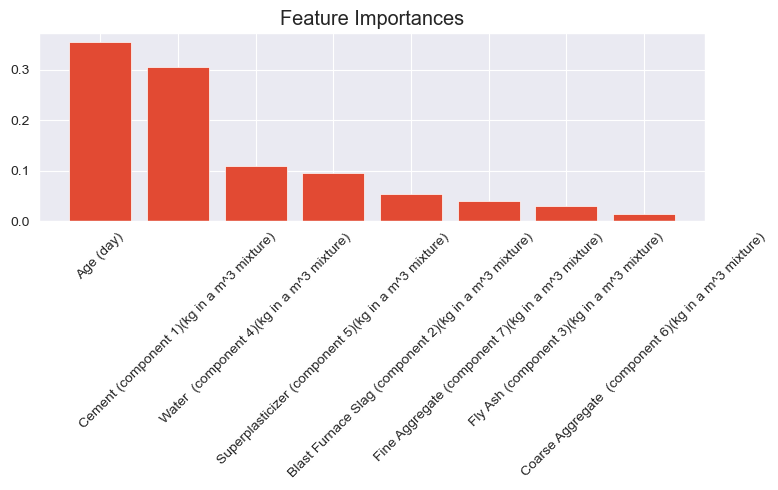

In [294]:
plt.figure(figsize=(8, 5))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=45)
plt.tight_layout()
plt.show()
plt.close() 

After fitting the Random Forest model, the feature importance analysis reveals which input variables most strongly influence the prediction. The feature **“Age”** is the most important, indicating it has the greatest impact on the concrete strength. **“Cement content”** follows as the second most influential feature. Other components like **Water, Superplasticizer, and Blast Furnace Slag** contribute moderately, while features such as **Fly Ash** have relatively low importance.

This insight helps to understand the key factors driving the model’s predictions, supports domain knowledge validation, and can guide feature selection or further data collection efforts.

Feature Selection

In [295]:
# List of all feature names in order, matching X_train columns
feature_names = [
    'Cement (component 1)(kg in a m^3 mixture)', 
    'Blast Furnace Slag (component 2)(kg in a m^3 mixture)', 
    'Fly Ash (component 3)(kg in a m^3 mixture)', 
    'Water  (component 4)(kg in a m^3 mixture)', 
    'Superplasticizer (component 5)(kg in a m^3 mixture)', 
    'Coarse Aggregate  (component 6)(kg in a m^3 mixture)', 
    'Fine Aggregate (component 7)(kg in a m^3 mixture)', 
    'Age (day)'
]

# Top features to keep
top_features = [
    'Age (day)', 
    'Cement (component 1)(kg in a m^3 mixture)', 
    'Water  (component 4)(kg in a m^3 mixture)', 
    'Superplasticizer (component 5)(kg in a m^3 mixture)', 
    'Blast Furnace Slag (component 2)(kg in a m^3 mixture)'
]

# Get their column indices
top_indices = [feature_names.index(f) for f in top_features]

# Select columns by index
X_train_reduced = X_train[:, top_indices]
X_test_reduced = X_test[:, top_indices]

# Train the model on reduced features
model_reduced = RandomForestRegressor(random_state=42)
model_reduced.fit(X_train_reduced, y_train)

# Predict and evaluate
y_pred_reduced = model_reduced.predict(X_test_reduced)
print("Test R²:", r2_score(y_test, y_pred_reduced))
print("Test MSE:", mean_squared_error(y_test, y_pred_reduced))


Test R²: 0.9204867924473622
Test MSE: 20.942160195112454


Using only the top 5 important features improved the model’s generalization and reduced noise from less relevant features.

Model Optimization - Hyperparameter Tuning for Random Forest using GridSearchCV

In [296]:

# Define the model
rf = RandomForestRegressor(n_estimators=200, random_state=0)

# Define the parameter grid to search
param_grid = {
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2']
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=kf, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit to training data
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best parameters:", grid_search.best_params_)

# Best model
best_rf = grid_search.best_estimator_


Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best parameters: {'max_depth': 20, 'max_features': 'log2'}


In [297]:
y_pred = best_rf.predict(X_test)
print("Test R²:", r2_score(y_test, y_pred))
print("Test MSE:", mean_squared_error(y_test, y_pred))

Test R²: 0.922266584183363
Test MSE: 20.473399283604863


Test R² improved slightly to ~0.92 (from 0.9205 before)

Test MSE decreased to ~20.64 (from 20.94 before)

This means the model’s performance got a bit better — more accurate and slightly more robust.

Model evaluation and diagnostic checking:

Residual Analysis

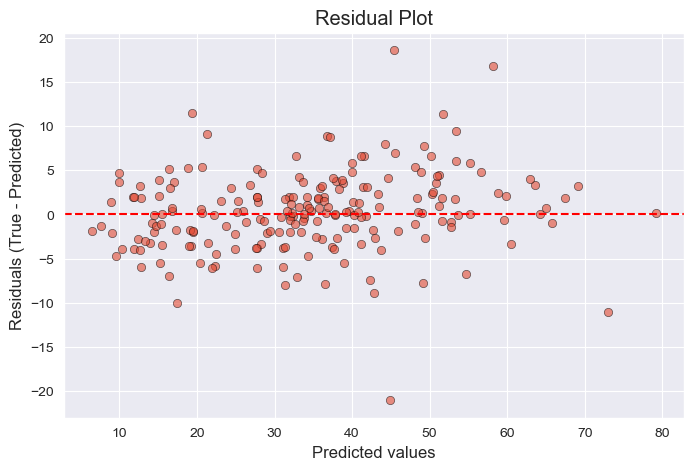

In [298]:
residuals = y_test - y_pred

plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.6, edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals (True - Predicted)')
plt.title('Residual Plot')
plt.show()


Out-Of-Bag (OOB) Error: We would like to set oob_score=True when creating RandomForestRegressor, and the model will estimate error internally using samples not used in each tree.

In [299]:
# Re-train model with OOB enabled
rf_oob = RandomForestRegressor(n_estimators=200, max_depth=best_rf.max_depth,
                               max_features=best_rf.max_features,
                               random_state=0, oob_score=True)
rf_oob.fit(X_train, y_train)

print(f"OOB R² score: {rf_oob.oob_score_:.4f}")


OOB R² score: 0.9110


OOB score being close to the test R² (~0.92) confirms the train-test split results are reliable and not overfitting.

#### 3. Gradient Boosting Model

creating and training a Gradient Boosting Regressor model on the traning data.

In [300]:
booster = GradientBoostingRegressor(
    loss='squared_error',        
    learning_rate=0.01,          
    n_estimators=200,            
    max_depth=3,                 
    random_state=0
)

boost_est = booster.fit(X_train, y_train)


Make predictions on the test set and evaluate model performance

In [301]:
y_pred = boost_est.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)

Test MSE: 58.88640348290601


feature importance plot

In [302]:
feature_importances = pd.Series(data=boost_est.feature_importances_, index=list(concrete_df.columns[:-1]))
sorted_feature_importances = feature_importances.sort_values(ascending=False)
sorted_feature_importances


Age (day)                                                0.396281
Cement (component 1)(kg in a m^3 mixture)                0.305334
Superplasticizer (component 5)(kg in a m^3 mixture)      0.112782
Water  (component 4)(kg in a m^3 mixture)                0.088723
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    0.059639
Fine Aggregate (component 7)(kg in a m^3 mixture)        0.026854
Fly Ash (component 3)(kg in a m^3 mixture)               0.007686
Coarse Aggregate  (component 6)(kg in a m^3 mixture)     0.002701
dtype: float64

The Gradient Boosting model identifies **"Age"** and **"Cement"** as the most influential factors in predicting the target variable, indicating these features have the strongest impact on the model’s predictions. Other features like **"Superplasticizer"** and **"Water"** also contribute notably but to a lesser degree. Features such as **"Coarse Aggregate"** and **"Fly Ash"** show minimal influence, suggesting they play a minor role in the prediction.

Partial dependence plots

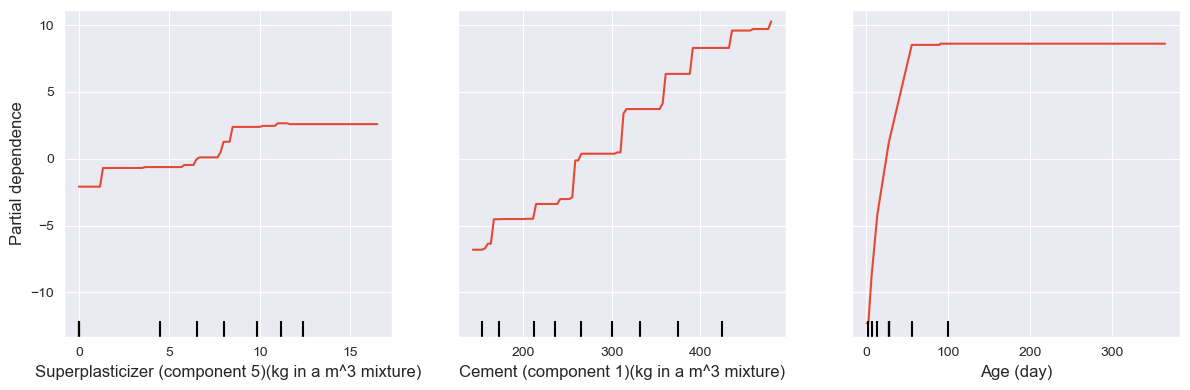

In [303]:
feature_idxs = np.argsort(feature_importances.values)[-3:]

# Plot PDP
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
PartialDependenceDisplay.from_estimator(
    boost_est,                  
    X_train,                    
    features=feature_idxs,      
    feature_names=feature_importances.index.tolist(),
    ax=ax
)
plt.tight_layout()
plt.show()

There might be an optimal range for **superplasticizer** where its positive effect on the predicted outcome is most pronounced, and further increases might not be beneficial. For **Cement**, the "steps" could suggest that the model has specific "regimes" or thresholds for cement content where the properties change significantly. Higher cement content generally leads to a better (higher) predicted outcome, but these improvements might not be linear. The plot of **Age**  implies that the most significant improvements in the predicted outcome due to aging occur within the first couple of months. Beyond this initial period, further aging has a negligible additional impact on the predicted outcome. This could indicate a saturation point where the material's properties stabilize.

Model refinement:

**Feature Selection** by keeping only the most important features based on the gradient boosting feature importances.
From the results, the most important features are: Age, Cement, Superplasticizer, water and Blast Furnance Slag.

In [304]:
important_features = [
    'Age (day)',
    'Cement (component 1)(kg in a m^3 mixture)',
    'Superplasticizer (component 5)(kg in a m^3 mixture)',
    'Water  (component 4)(kg in a m^3 mixture)',
    'Blast Furnace Slag (component 2)(kg in a m^3 mixture)'
]

X_selected = concrete_df[important_features]
y = concrete_df['Concrete compressive strength(MPa, megapascals)']  # Replace 'target_column' with your target variable column name

X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
    X_selected, y, test_size=0.2, random_state=0)

booster_sel = GradientBoostingRegressor(
    loss='squared_error',        # corrected here
    learning_rate=0.001,
    n_estimators=5000,
    max_depth=4,
    random_state=0
)

boost_est_sel = booster_sel.fit(X_train_sel, y_train_sel)

y_pred_sel = boost_est_sel.predict(X_test_sel)
mse_sel = mean_squared_error(y_test_sel, y_pred_sel)
print("Test MSE with selected features:", mse_sel)


Test MSE with selected features: 27.248453288441535


Feature selection focusing on PDP results:

In [305]:
# Select features strongly supported by PDP interpretation
important_features_pdp = [
    'Age (day)',
    'Cement (component 1)(kg in a m^3 mixture)',
    'Superplasticizer (component 5)(kg in a m^3 mixture)'
]

X_selected_pdp = concrete_df[important_features_pdp]
y = concrete_df['Concrete compressive strength(MPa, megapascals)']


# Set up the gradient boosting regressor with early stopping
booster_sel = GradientBoostingRegressor(
    loss='squared_error',
    learning_rate=0.01,      
    n_estimators=1000,       
    max_depth=4,
    random_state=0,
    validation_fraction=0.1, 
    n_iter_no_change=50,  
    tol=1e-4
)

# Fit model with early stopping
boost_est_sel = booster_sel.fit(X_train_sel, y_train_sel)

# Predictions and evaluation
y_pred_sel = boost_est_sel.predict(X_test_sel)
mse_sel = mean_squared_error(y_test_sel, y_pred_sel)

print("Test MSE with PDP-based selected features:", mse_sel)


Test MSE with PDP-based selected features: 27.119307187544667


Interpretation: The dropped features might still contain some usefull inforamtion, even if their importance seemed slow.

Model optimization

Hyperparameter Tuning for GradientBoostingRegressor using RandomizedSearchCV: 

In [306]:
# Define the model
gbr = GradientBoostingRegressor(random_state=0)

# Define hyperparameter search space
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_dist,
    n_iter=50,           # number of parameter settings sampled
    cv=kf,                # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # minimize MSE
    n_jobs=-1,           # use all cores
    random_state=0,
    verbose=1
)

# Fit the random search to the training data
random_search.fit(X_train, y_train)

# Get the best model
best_booster = random_search.best_estimator_

# Predict on test data
y_pred = best_booster.predict(X_test)

# Calculate MSE and R2 score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best parameters: {random_search.best_params_}")
print(f"Test MSE: {mse:.4f}")
print(f"Test R2 score: {r2:.4f}")


Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best parameters: {'subsample': 0.6, 'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 5, 'learning_rate': 0.1}
Test MSE: 17.3755
Test R2 score: 0.9340


The Gradient Boosting model uses carefully chosen hyperparameters to balance accuracy and generalization. It builds 500 trees with a maximum depth of 4, limiting complexity to avoid overfitting. Each tree is trained on 60% of the data and considers only a subset of features at each split, adding randomness to improve robustness. Minimum samples per split and leaf prevent overly specific rules, while a learning rate of 0.1 ensures gradual, stable learning. Overall, these settings help the model perform well on unseen data while avoiding overfitting. The tuned Gradient Boosting model shows strong predictive performance, achieving a low test MSE of 17.38 and a high R² of 0.93.

Model evaluation and diagnostic checking:

Residual Analysis: check if errors are randomly distributed and there's no systematic bias.

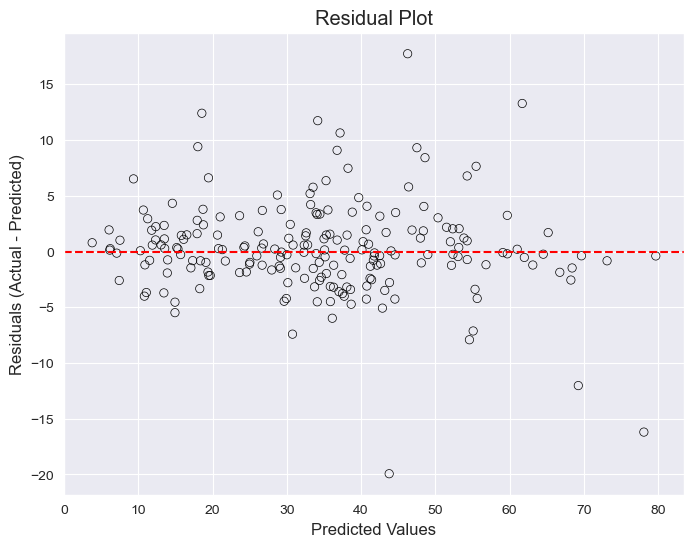

In [307]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, edgecolor='k', facecolor='none')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.show()

The residual plot shows that the residuals are evenly scattered around zero without any clear pattern, indicating that the model's errors are randomly distributed. The consistent spread of residuals suggests that the assumption of constant variance is met, and although there are a few isolated outliers, they do not undermine the overall fit. This implies that the model captures the data well, with no strong bias or missed nonlinear relationships.

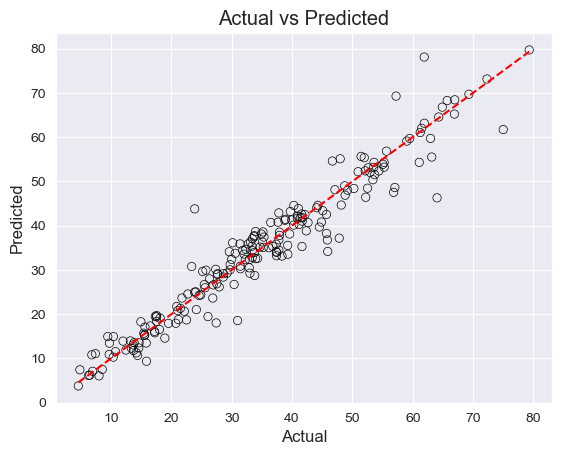

In [308]:
plt.scatter(y_test, y_pred, edgecolor='k', facecolor='none')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()
plt.close()

Train vs. Test Performance

In [309]:
# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# R²
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# RMSE
rmse_train = root_mean_squared_error(y_train, y_train_pred)
rmse_test =root_mean_squared_error(y_test, y_test_pred)

print(f"Train R²: {r2_train:.3f}, Test R²: {r2_test:.3f}")
print(f"Train RMSE: {rmse_train:.3f}, Test RMSE: {rmse_test:.3f}")


Train R²: 0.985, Test R²: 0.923
Train RMSE: 2.058, Test RMSE: 4.503


The gradient boosting model shows excellent fit on training data and still performs very well on test data. The performance drop is moderate and expected in real-world modeling. There is no strong evidence of overfitting.

## 5. Experiments

## 6. Conclusion

In this study, we explored the relationships between the composition of concrete mixtures and their corresponding compressive strength through data-driven analysis. 

In **Chapter 1**, the problem under discussion is introduced and the objective of the study is defined.

A concise explanation of the dataset is provided in **Chapter 2**, along with information on its availability.

The data preprocessing phase, as discussed in **Chapter 3**, included standardization and feature engineering particularly the creation of the water-binder ratio and logarithmic age transformation, which helped reveal non-linear effects and improved model performance. Visual exploration and correlation analysis indicated that water content negatively affects strength, aligning with established domain knowledge such as the Abrams' law.

**not done yet**

Several regression models were in **Chapter 4** evaluated, including Linear Regression, Decision Trees, and ensemble methods. Among them, tree-based models demonstrated superior performance in capturing complex, non-linear interactions between variables. The results suggest that robust, assumption-light models are better suited for this dataset due to the irregular and skewed distribution of target values.

Overall, this analysis provides valuable insights into the importance of feature interactions in predicting concrete strength and highlights the potential of machine learning methods in advancing material design and quality control.

Compare …, the best result is from….

The most important features

What could have done, if we had more time on this project
(